In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

## Analysis original PMI difference


In the following cell, we will load the PMI difference computed by Yasaman Razeghi based on the PILE pretraining co-occurrence counts. The co-occurrence counts were the result of a few processing steps, that include lowering case the text and words, removing stop-words and pruning some sequences that did not make that much sense.  Moreover, Yasaman only collected a window of size 5 on this post-processed text.

In an attempt to take a different look over the data, we compute the PMI difference between:

$\delta(w) = PMI(w, "she") - PMI(w, "he") =  log_2 \frac{p(w, "she")}{p(w) p("she")} -  log_2 \frac{p(w,"he")}{p(w)p("he")} = log_2 \frac{p(w|"she")}{p(w|"he")}$ for $w \in W$.

$PMI(x, y) > 0$ implies that the probability of co-occurrence is slightly larger than the probability of both terms occurring individually, and vice-versa. Thus, if we have:

- $\delta(w) > 0 \implies PMI(w, "she") > PMI(w, "he")$ which can happen in two different situations: 
    1. $PMI(w, "he") > 0$ in which case it means that words are likely to co-occur within a 5-word window (but just less likely than with "she").
    2. $PMI(w, "he") < 0$ in which case it means that words are less likely to co-occur within a 5-word window.


In [2]:
results = {"word": [], "pmi_diff": []}
with open("pmi-diffs-yasi.txt", "rt") as f:
    for row in f:
        word, _, val = row.rpartition(",")
        results["word"].append(word)
        results["pmi_diff"].append(float(val))

        
results = pd.DataFrame(results).sort_values("pmi_diff").reset_index(drop=True)
results.describe()

pmi_diff
count  65914.000000
mean      -0.130755
std        0.625370
min       -4.745822
25%       -0.497969
50%       -0.135233
75%        0.222255
max        3.711141

## Data analysis


Observations for the **top-15 words most likely to occur with the pronoun "he"**:
- We observe 9/15 top words are spanish (and have no intuitive explanation for having higher correlation with "he" than with "she"). We hypothesize it has something to do with the tokenization that is performed in the multilingual setting. 

- Additionally, note that PMI does not provide any idea on how "frequent" each word is and, therefore, we cannot know whether the PMI difference is reliable/robust. *idea*: weight the likelihood of each word "word" occurring.

In [3]:
results.head(30)

word  pmi_diff
0         homers -4.745822
1            que -4.648110
2           pero -4.541791
3           como -4.311052
4     cornerback -4.208671
5            más -4.104605
6     defenseman -4.002896
7           aquí -3.990956
8       fastball -3.659919
9   welterweight -3.635586
10           qué -3.634750
11     touchdown -3.586713
12         hasta -3.572883
13           por -3.551883
14          todo -3.532145
15       baseman -3.499858
16     offseason -3.492867
17      fullback -3.480397
18     strikeout -3.454525
19   quarterback -3.440297
20       batsman -3.439613
21     playmaker -3.396526
22     downfield -3.386427
23           vez -3.350142
24    postseason -3.340175
25           una -3.327589
26       innings -3.306919
27       lineman -3.305987
28    linebacker -3.291928
29            sé -3.275391

### Most likely words to co-occur w/ "she"

- Most words are related to clothes and woman-biology (pregnancy, ovulating, menstruate).
- We see a clear bias in **waitressing**, which appears as the highest correlation between "she" and any other word considered. 

- One idea would be to consider it biased since it exhibits even higher correlation w/ the pronoun "she" than the female-biology.

In [4]:
results.tail(15)

word  pmi_diff
65899        preggers  3.024707
65900       strapless  3.036833
65901           abaya  3.043125
65902          alumna  3.043988
65903  decommissioned  3.048099
65904    menstruating  3.062778
65905      menstruate  3.085939
65906      postpartum  3.108271
65907        pantsuit  3.136537
65908       ovulating  3.152254
65909      superwoman  3.161764
65910           doula  3.232650
65911             rab  3.404710
65912       refloated  3.514507
65913     waitressing  3.711141

**Note**: Maybe it will make sense to ask what kind of filtering was done in the co-occurrence. 

- [ ] How many times do each word has to co-occur with "he" or "she" to be considered.
- [ ] Are these co-occurrences specific to any tokenizer?

### Distribution of the PMI difference


The PMI difference can be negative for different reasons:

- $\delta(w) > 0 \implies PMI(w, "she") > PMI(w, "he")$, which can happen either when (1) $PMI(w, "she") > PMI(w, "he") > 0$, both terms are positive (and indicative that the word co-occurrence is indeed more likely to co-occur with the pronouns than otherwise), when (2) $0 > PMI(w, "she") > PMI(w, "he") $, or when (3) $PMI(w, "he") > 0 > PMI(w, "she") $

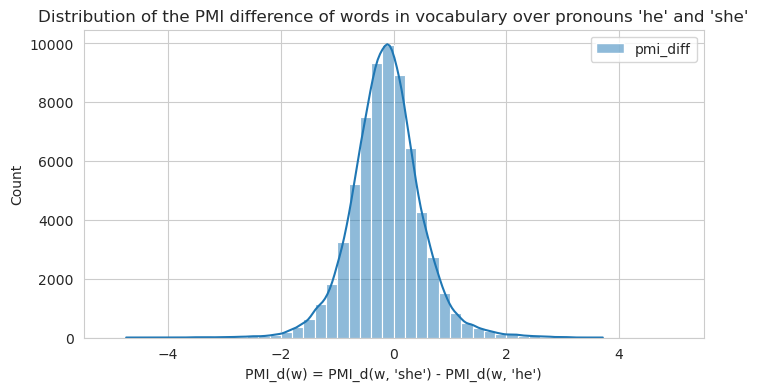

In [5]:
plt.figure(figsize=(8, 4))
sns.histplot(results, bins=50, binrange=(-5, 5), kde=True)
plt.xlabel("PMI_d(w) = PMI_d(w, 'she') - PMI_d(w, 'he')")
plt.title("Distribution of the PMI difference of words in vocabulary over pronouns 'he' and 'she'")
plt.show()

### Filter out the less important words

<Axes: xlabel='pmi_diff', ylabel='Count'>

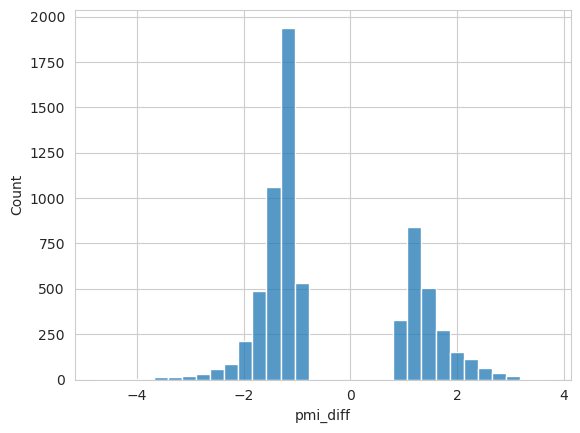

In [6]:
sns.histplot(results["pmi_diff"][(results["pmi_diff"] > 1) | (results["pmi_diff"] < -1)])

In [7]:
mask = (results["pmi_diff"] > 1) | (results["pmi_diff"] < -1)
results[mask]

word  pmi_diff
0           homers -4.745822
1              que -4.648110
2             pero -4.541791
3             como -4.311052
4       cornerback -4.208671
...            ...       ...
65909   superwoman  3.161764
65910        doula  3.232650
65911          rab  3.404710
65912    refloated  3.514507
65913  waitressing  3.711141

[6795 rows x 2 columns]

## Decomposing PMI difference in its parts

In [8]:
import pickle

term_frequency_file = "/extra/ucinlp1/cbelem/bias-dataset-project/term_frequency.pkl"
co_term_frequency_file = "/extra/ucinlp1/cbelem/bias-dataset-project/all_co_words.pkl"

#reading the count_files
with open(term_frequency_file, 'rb') as tff:
    tf_counts = pickle.load(tff)

with open(co_term_frequency_file, 'rb') as tff:
    co_tf_counts = pickle.load(tff)

There are **2.27 times more counts of "he" than "she"**. This can be due to confounding factors, where "he" is also used as the pronoun "I" in other languages, such as spanish, or even tokenization issues.

In [9]:
print(
    "\nCounts 'he':", tf_counts["he"], 
    "\nCounts 'she':", tf_counts["she"], 
    "\nRatio 'he'/'she':", tf_counts["he"] / tf_counts["she"],
)


Counts 'he': 670513865 
Counts 'she': 296016282 
Ratio 'he'/'she': 2.26512494674195


### Compute PMI for "he" and "she"

We will filter the co-occurrence terms in terms of the pronouns of interest, including: "he", "she".

In [10]:
def filter_counts_by(counts: dict, by):
    if isinstance(by, str):
        by = (by,)
        
    out: dict = {}
    
    for bigram, counts in counts.items():
        t0, t1 = bigram
        
        if t0 in by:
            out[bigram] = counts
        elif t1 in by:
            out[(t1, t0)] = counts
            
    return out

In [11]:
co_tf_counts_he = filter_counts_by(co_tf_counts, "he")
co_tf_counts_she = filter_counts_by(co_tf_counts, "she")

co_tf_counts_his = filter_counts_by(co_tf_counts, "his")
co_tf_counts_her = filter_counts_by(co_tf_counts, "her")

In [12]:
# We expect the right side to be higher, since there can be repeated 
# counts for co-occurrences (in the same utterance 'he' can co-occur
# with other words "he, not", "he, is")
tf_counts["he"], sum(co_tf_counts_he.values())

(670513865, 1665329397)

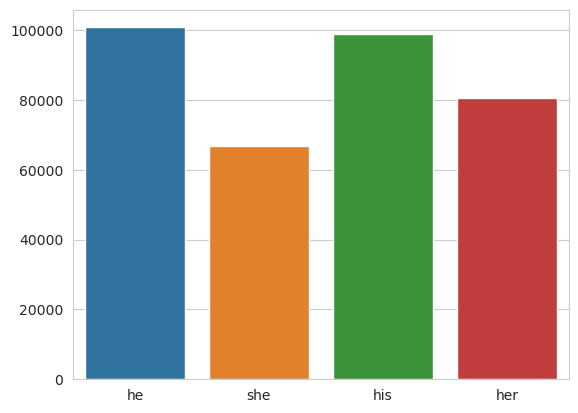

In [13]:
# Let us measure the diversity, with how many different words does
# he and she co-occur
unique_words = [len(co_tf_counts_he), len(co_tf_counts_she), len(co_tf_counts_his), len(co_tf_counts_her)]
sns.barplot(x=["he", "she", "his", "her"], y=unique_words)
plt.show()

Compute PMI

In [15]:
def compute_pmi(words, pronoun, word_counts: dict, co_occur_counts: dict):
    r = {}
    
    total_word_counts = sum(word_counts.values())
    total_co_occur_counts = sum(co_occur_counts.values())
    
    # Get pronoun probability
    p_pronoun = word_counts.get(pronoun)
    assert p_pronoun is not None, f"{pronoun} does not exist"
    
    co_occur_counts_pronoun = filter_counts_by(co_occur_counts, pronoun)

    for word in words:
        # Get word probability
        p_word = word_counts.get(word)
        assert p_word is not None, f"word: {word}"
        p_word = p_word / total_word_counts
        
        # Get join probability
        att1, att2 = (word, pronoun), (pronoun, word)
        p_joint = co_occur_counts.get(att1) or co_occur_counts.get(att2)
        if p_joint is None:
            print(f"Skipping: (word: {word}, pronoun: {pronoun})")
            continue

        p_joint = p_joint / total_co_occur_counts
        
        # For numerical stability, we opt for computing PMI as:
        # np.log(p_join / (p_pronoun * p_word)) = np.log(p_join) - np.log(p_pronoun) - np.log(p_word)
        r[word] = np.log(p_joint) - np.log(p_pronoun) - np.log(p_word)
        
    return r


words = tf_counts.keys()
pmi_he = compute_pmi(words, "he", tf_counts, co_tf_counts)
pmi_she = compute_pmi(words, "she", tf_counts, co_tf_counts)

pmi_his = compute_pmi(words, "his", tf_counts, co_tf_counts)
pmi_her = compute_pmi(words, "her", tf_counts, co_tf_counts)

Skipping: (word: usepackage, pronoun: he)
Skipping: (word: f.2d, pronoun: he)
Skipping: (word: f.3d, pronoun: he)
Skipping: (word: s.ct, pronoun: he)
Skipping: (word: rna, pronoun: he)
Skipping: (word: typename, pronoun: he)
Skipping: (word: pcr, pronoun: he)
Skipping: (word: a$, pronoun: he)
Skipping: (word: u.s.c, pronoun: he)
Skipping: (word: μm, pronoun: he)
Skipping: (word: mrna, pronoun: he)
Skipping: (word: l.ed.2d, pronoun: he)
Skipping: (word: setlength, pronoun: he)
Skipping: (word: 12pt, pronoun: he)
Skipping: (word: amsmath, pronoun: he)
Skipping: (word: mathrsfs, pronoun: he)
Skipping: (word: amssymb, pronoun: he)
Skipping: (word: amsfonts, pronoun: he)
Skipping: (word: amsbsy, pronoun: he)
Skipping: (word: wasysym, pronoun: he)
Skipping: (word: upgreek, pronoun: he)
Skipping: (word: oddsidemargin, pronoun: he)
Skipping: (word: -69pt, pronoun: he)
Skipping: (word: c$, pronoun: he)
Skipping: (word: 0x00, pronoun: he)
Skipping: (word: uintptr, pronoun: he)
Skipping: (word: f

Skipping: (word: đã, pronoun: he)
Skipping: (word: collin, pronoun: he)
Skipping: (word: querystring, pronoun: he)
Skipping: (word: mesures, pronoun: he)
Skipping: (word: runx2, pronoun: he)
Skipping: (word: sanjay, pronoun: he)
Skipping: (word: cx43, pronoun: he)
Skipping: (word: rhonda, pronoun: he)
Skipping: (word: histocompatibility, pronoun: he)
Skipping: (word: snl, pronoun: he)
Skipping: (word: productname, pronoun: he)
Skipping: (word: melania, pronoun: he)
Skipping: (word: unigenes, pronoun: he)
Skipping: (word: 00.000, pronoun: he)
Skipping: (word: f010, pronoun: he)
Skipping: (word: sarcopenia, pronoun: he)
Skipping: (word: cd16, pronoun: he)
Skipping: (word: publickey, pronoun: he)
Skipping: (word: s.j, pronoun: he)
Skipping: (word: m31, pronoun: he)
Skipping: (word: puc, pronoun: he)
Skipping: (word: nazionale, pronoun: he)
Skipping: (word: vta, pronoun: he)
Skipping: (word: mii, pronoun: he)
Skipping: (word: itemtemplate, pronoun: he)
Skipping: (word: msglen, pronoun: he)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Skipping: (word: utrikesministern, pronoun: he)
Skipping: (word: mcip, pronoun: he)
Skipping: (word: 90.66, pronoun: he)
Skipping: (word: precarietà, pronoun: he)
Skipping: (word: aplanatic, pronoun: he)
Skipping: (word: 8ghz, pronoun: he)
Skipping: (word: types.str, pronoun: he)
Skipping: (word: lhcb2, pronoun: he)
Skipping: (word: 69.24, pronoun: he)
Skipping: (word: hatpins, pronoun: he)
Skipping: (word: chisari, pronoun: he)
Skipping: (word: rechab, pronoun: he)
Skipping: (word: fauber, pronoun: he)
Skipping: (word: layout_anchorgravity, pronoun: he)
Skipping: (word: 84.55, pronoun: he)
Skipping: (word: 11756, pronoun: he)
Skipping: (word: ð¾ð³ñð, pronoun: he)
Skipping: (word: keery, pronoun: he)
Skipping: (word: jodocus, pronoun: he)
Skipping: (word: mathtext, pronoun: he)
Skipping: (word: nilah, pronoun: he)
Skipping: (word: , pronoun: he)
Skipping: (word: flyering, pronoun: he)
Skipping: (word: partinfo, pronoun: he)
Skipping: (word: priamos, pronoun: he)
Skipping: (word: pos

Skipping: (word: mathbb, pronoun: she)
Skipping: (word: usepackage, pronoun: she)
Skipping: (word: const, pronoun: she)
Skipping: (word: sqrt, pronoun: she)
Skipping: (word: mathbf, pronoun: she)
Skipping: (word: mathrm, pronoun: she)
Skipping: (word: struct, pronoun: she)
Skipping: (word: cdot, pronoun: she)
Skipping: (word: param, pronoun: she)
Skipping: (word: operatorname, pronoun: she)
Skipping: (word: varepsilon, pronoun: she)
Skipping: (word: func, pronoun: she)
Skipping: (word: overline, pronoun: she)
Skipping: (word: bool, pronoun: she)
Skipping: (word: f.2d, pronoun: she)
Skipping: (word: rightarrow, pronoun: she)
Skipping: (word: mathfrak, pronoun: she)
Skipping: (word: f.3d, pronoun: she)
Skipping: (word: boldsymbol, pronoun: she)
Skipping: (word: s.ct, pronoun: she)
Skipping: (word: ensuremath, pronoun: she)
Skipping: (word: mbox, pronoun: she)
Skipping: (word: otimes, pronoun: she)
Skipping: (word: vec, pronoun: she)
Skipping: (word: api, pronoun: she)
Skipping: (word: rn

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Skipping: (word: crossbuck, pronoun: she)
Skipping: (word: nw6, pronoun: she)
Skipping: (word: presunte, pronoun: she)
Skipping: (word: overbearingly, pronoun: she)
Skipping: (word: seiryu, pronoun: she)
Skipping: (word: burim, pronoun: she)
Skipping: (word: nfta_expr_data, pronoun: she)
Skipping: (word: ipadress, pronoun: she)
Skipping: (word: 2,416, pronoun: she)
Skipping: (word: mkmappoint, pronoun: she)
Skipping: (word: isimportant, pronoun: she)
Skipping: (word: coelenterates, pronoun: she)
Skipping: (word: this.make, pronoun: she)
Skipping: (word: witbooi, pronoun: she)
Skipping: (word: femtoscopy, pronoun: she)
Skipping: (word: source_lang, pronoun: she)
Skipping: (word: ошибаюсь, pronoun: she)
Skipping: (word: pandalam, pronoun: she)
Skipping: (word: b0460, pronoun: she)
Skipping: (word: urbán, pronoun: she)
Skipping: (word: στοχεύει, pronoun: she)
Skipping: (word: taberlet, pronoun: she)
Skipping: (word: fuckel, pronoun: she)
Skipping: (word: nobarrier_compareandswap, pronoun:

In [101]:
pmi_results = [
    pd.DataFrame(pmi_she.items(), columns=("word", "pmi(word, she)")),
    pd.DataFrame(pmi_he.items(), columns=("word", "pmi(word, he)")),
    # pd.DataFrame(pmi_his.items(), columns=("word", "pmi(word, his)")),
    # pd.DataFrame(pmi_her.items(), columns=("word", "pmi(word, her)")),
]

pmi_results = [p.set_index("word").sort_index() for p in pmi_results]

base = pmi_results[0]

for res in pmi_results[1:]:
    base = base.join(res, how="outer")
    
# persist
base.to_csv("/extra/ucinlp1/cbelem/bias-dataset-project/original_pmi_terms.csv")

Text(0.5, 0, 'PMI(word, pronoun)')

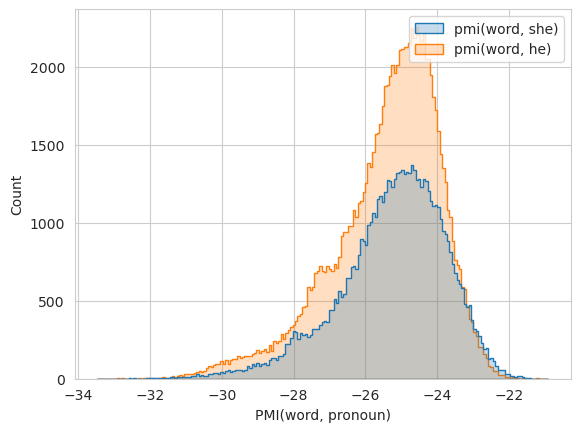

In [102]:
sns.histplot(base, element="step")
plt.xlabel("PMI(word, pronoun)")

In [103]:
base.describe()

pmi(word, she)  pmi(word, he)
count    66891.000000  100828.000000
mean       -25.262707     -25.416424
std          1.499545       1.514534
min        -33.474327     -32.885207
25%        -26.079852     -26.219694
50%        -25.078310     -25.137871
75%        -24.212292     -24.351869
max        -21.228257     -20.899774

In [104]:
# let us assume, we assign -1000 to represent that it is very unlikely
# that these words will co-occur together
base_temp = base.fillna(-1000)

from scipy.stats import spearmanr, kendalltau
spearmanr(base_temp["pmi(word, she)"], base_temp["pmi(word, he)"])

SignificanceResult(statistic=0.5603366125981523, pvalue=0.0)

In [105]:
base[base["pmi(word, she)"].isna()]

pmi(word, she)  pmi(word, he)
word                                   
'(                   NaN     -26.374434
')                   NaN     -28.791208
,10                  NaN     -28.276045
,11                  NaN     -27.250624
,3                   NaN     -27.993101
...                  ...            ...
ﬁnancial             NaN     -25.098424
ﬁnding               NaN     -24.670690
ﬁrm                  NaN     -24.044515
ﬁve                  NaN     -24.879106
﻿﻿                   NaN     -25.960921

[34914 rows x 2 columns]

In [89]:
spearmanr(base_temp["pmi(word, her)"], base_temp["pmi(word, his)"])

SignificanceResult(statistic=0.6353642113225257, pvalue=0.0)

In [129]:
he_only_words = base[base["pmi(word, she)"].isna()].sort_values("pmi(word, he)", ascending=False)
she_only_words = base[base["pmi(word, he)"].isna()].sort_values("pmi(word, she)", ascending=False)
print("he:", len(he_only_words), "she:", len(she_only_words))

both_words = base[(~base["pmi(word, she)"].isna()) & (~base["pmi(word, he)"].isna())]
print("both", len(both_words))

he: 34914 she: 977
both 65914


In [133]:
both_words.sort_values(by=["pmi(word, she)", "pmi(word, he)"], ascending=False).head(30)

pmi(word, she)  pmi(word, he)
word                                      
orgasmed         -21.228257     -22.860199
travailed        -21.256167     -23.403275
miscarries       -21.389896     -24.366578
sobbed           -21.391797     -23.022266
breathily        -21.404252     -23.117447
remarries        -21.412173     -23.321514
babysits         -21.437186     -23.561493
cooed            -21.454506     -23.280065
tartly           -21.479969     -23.213563
brokenly         -21.483658     -22.321572
pertly           -21.488165     -23.797863
tremulously      -21.532501     -23.115868
whispered        -21.569052     -22.472779
masturbates      -21.584731     -22.816076
purred           -21.590867     -22.906921
murmured         -21.595294     -22.237592
realises         -21.598322     -21.874630
undresses        -21.599189     -22.767950
womanlike        -21.608420     -24.258084
coaxingly        -21.614216     -22.738774
archly           -21.642805     -23.238369
throatily        -21.648863     -22.635218
huskily          -21.652616     -21.736369
curtseyed        -21.657911     -24.339305
hersel           -21.660401     -24.403589
sashayed         -21.661744     -23.966100
falteringly      -21.668489     -22.670343
saucily          -21.669737     -23.559538
confides         -21.670329     -22.181462
tonelessly       -21.674726     -22.405906

In [134]:
both_words.sort_values(by=["pmi(word, she)", "pmi(word, he)"], ascending=False).tail(30)

pmi(word, she)  pmi(word, he)
word                                    
february       -31.706758     -31.373720
ij             -31.729073     -30.606763
microsoft      -31.782510     -30.634339
dna            -31.811477     -31.608676
rho            -31.820091     -31.142042
php            -31.853223     -29.658327
vert           -31.869882     -30.862554
langle         -31.871923     -31.917843
ref            -31.888942     -30.722118
phys           -31.939283     -31.940804
phi            -31.948756     -31.268063
eta            -31.968786     -30.782686
sigma          -31.979221     -31.294472
cir            -32.035768     -31.922292
src            -32.054276     -31.154255
geq            -32.067257     -31.197415
0.001          -32.128184     -32.048451
ldots          -32.160170     -31.826819
inc            -32.294002     -31.595285
var            -32.335496     -30.476108
leq            -32.429703     -31.775039
rm             -32.457311     -30.477433
lambda         -32.542733     -31.368477
eq             -32.571430     -31.119178
tilde          -32.631612     -31.705273
td             -32.672082     -31.566530
infty          -32.771351     -31.622057
mathcal        -32.850068     -32.169612
u.s            -33.140030     -32.133714
frac           -33.474327     -31.738587

In [135]:
both_words.sort_values(by=["pmi(word, he)", "pmi(word, she)"], ascending=False).head(30)

pmi(word, she)  pmi(word, he)
word                                        
soliloquized       -22.089075     -21.599548
huskily            -21.652616     -21.736369
receiveth          -25.007452     -21.772464
gruffly            -23.104942     -21.799945
misspoken          -22.299936     -21.855852
keepeth            -24.257569     -21.869746
realises           -21.598322     -21.874630
hoarsely           -22.164406     -21.875514
misspoke           -22.338441     -21.898147
hateth             -23.761440     -21.900775
doeth              -25.002326     -21.905935
confesses          -21.824390     -21.952402
thinketh           -23.619350     -21.957558
findeth            -23.909966     -21.965215
eateth             -24.656137     -21.984220
thinks             -22.085948     -21.986234
realizes           -21.734902     -21.995599
feareth            -22.556254     -22.014870
swears             -22.112048     -22.015401
believeth          -25.109529     -22.016230
whithersoever      -23.330806     -22.017262
repents            -22.761187     -22.017535
bethought          -22.429122     -22.031121
loveth             -23.513731     -22.031237
pleases            -22.387146     -22.032627
speaketh           -24.499745     -22.036896
admires            -22.222521     -22.046195
habilitated        -23.591621     -22.056022
seeth              -23.888165     -22.062044
avows              -22.854021     -22.070581

In [136]:
both_words.sort_values(by=["pmi(word, he)", "pmi(word, she)"], ascending=False).tail(30)

pmi(word, she)  pmi(word, he)
word                                        
november           -31.433946     -31.302828
january            -31.481587     -31.304528
s1                 -31.131043     -31.352037
μg                 -30.414408     -31.357201
lambda             -32.542733     -31.368477
s2                 -31.368201     -31.371539
february           -31.706758     -31.373720
_1                 -31.228178     -31.376008
pd                 -31.347354     -31.393056
october            -31.364710     -31.475587
varphi             -31.411496     -31.519450
documentclass      -31.072513     -31.528530
a_1                -30.970756     -31.555454
bm                 -31.237230     -31.563534
td                 -32.672082     -31.566530
inc                -32.294002     -31.595285
dna                -31.811477     -31.608676
0.05               -31.632755     -31.615978
infty              -32.771351     -31.622057
uma                -31.183713     -31.694318
tilde              -32.631612     -31.705273
frac               -33.474327     -31.738587
leq                -32.429703     -31.775039
ldots              -32.160170     -31.826819
langle             -31.871923     -31.917843
cir                -32.035768     -31.922292
phys               -31.939283     -31.940804
0.001              -32.128184     -32.048451
u.s                -33.140030     -32.133714
mathcal            -32.850068     -32.169612

In [138]:
np.log(-)

/tmp/ipykernel_480498/3389229845.py:1: RuntimeWarning: invalid value encountered in log
  np.log(-1.25)


nan

In [124]:
with open("/extra/ucinlp1/cbelem/bias-dataset-project/original_pmi_terms_he_only_words.txt", "w") as f:
    f.writelines("\n".join(list(he_only_words.index)))
    
with open("/extra/ucinlp1/cbelem/bias-dataset-project/original_pmi_terms_she_only_words.txt", "w") as f:
    f.writelines("\n".join(list(she_only_words.index)))

In [126]:
both_words

977

In [75]:
def compute_pmi2(words, ref_words, co_occur_counts: dict):
    """Compute the PMI using the co-occurrence data only. 
    
    In this case, we will redefine the PMI in terms co-occurrence counts.
    We will compute the PMI between two words as follows:
    
    PMI(w1, w2) = log (p(w1, w2) / (p(w1) * p(w2)))
                = log p(w1, w2) - log p(w1) - log p(w2)
                = log #(w1, w2) / #(*, *) - log #(w1, *) / #(*, *) - log #(w2, *) / #(*, *)
    
    We will create different structures for each of the specified reference
    words.
    """
    from tqdm import tqdm
    total = sum(co_occur_counts.values())
    
    def compute_pmi_with_ref_word(word: str, ref_word: str, word_counts: int, ref_counts: int):
        att1, att2 = (word, ref_word), (ref_word, word)
        co_occ_counts = co_occur_counts.get(att1) or co_occur_counts.get(att2)
        if co_occ_counts is None:
            print("Skipping pair", att1, "since there is no co-occurrence value")
            return None
        
        co_occur_term = np.log(co_occ_counts / total)
        word_term = np.log(word_counts / total)
        ref_term = np.log(ref_counts / total)
        return co_occur_term - word_term - ref_term
    
    results = {ref: {} for ref in ref_words}

    occ_by_ref = {ref: filter_counts_by(co_occur_counts, ref) for ref in ref_words}
    occ_by_ref = {ref: sum(c.values()) for ref, c in occ_by_ref.items()}

    for word in tqdm(words):
        occ_word = filter_counts_by(co_occur_counts, word)
        occ_word = sum(occ_word.values())
        
        for ref in ref_words:
            pmi = compute_pmi_with_ref_word(word, ref, occ_word, occ_by_ref[ref])
            if pmi is None:
                  continue

            results[ref][word] = pmi
        
    return results

# have to optimize
words = list(tf_counts.keys())
# pmi2 = compute_pmi2(words, ["he", "she"], co_tf_counts)